**Fraud Analytics Assignment**  
**Title: Example-dependent cost-sensitive regression**  
---
**Group members:**  
**Name&emsp;: Dindorkar Mayuresh Rajesh**  
**Roll No&nbsp;: CS23MTECH14007**  

**Name&emsp;: Sanyam Kaul**  
**Roll No&nbsp;: CS23MTECH14011**  

**Name&emsp;: Shrenik Ganguli**  
**Roll No&nbsp;: CS23MTECH14014**  

**Name&emsp;: Morey Piyush Prabhakar**  
**Roll No&nbsp;: AI23MTECH14003**  

---

In [1]:
# Library used for genetic algorithm
!pip install pygad

**Importing libraries:**

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.linear_model import LogisticRegression
import seaborn as sns
warnings.filterwarnings("ignore")
import pygad
from scipy.optimize import minimize

---  
**Utility Functions:**

In [3]:
def count_labels(data, column_name):
    return data[column_name].value_counts()

In [4]:
def plot_bar_chart(label_counts):
    labels = label_counts.index.tolist()
    counts = label_counts.values
    plt.bar(np.arange(len(labels)), counts, color=['blue', 'orange'])
    plt.ylabel('Count')
    plt.xlabel('Status')
    plt.title(f'Count of labels in the Status column')
    plt.xticks(np.arange(len(labels)), labels)
    plt.show()

In [5]:
def perform_scaling(X_train, X_test):
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)
    return std_scaler, X_train, X_test

In [6]:
# Returns FP, TP, TN, FNC
def get_cost_matrix_values(Y_train):
    num_of_samples = X_train.shape[0]
    return np.full(num_of_samples, 6), np.full(num_of_samples, 6), np.zeros(num_of_samples), Y_train.iloc[:,1].values

In [7]:
def compute_sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [8]:
def calculate_saving(simple_lr_cost, cost_of_cslr):
    return (simple_lr_cost - cost_of_cslr) / simple_lr_cost

---

**Reading the dataset:**

In [9]:
df = pd.read_csv('costsensitiveregression.csv')
df.head()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0,0.0,1,0.0
2,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
3,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,0.0
4,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147636 entries, 0 to 147635
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   NotCount  147636 non-null  int64  
 1   YesCount  147636 non-null  int64  
 2   ATPM      147636 non-null  float64
 3   PFD       147636 non-null  float64
 4   PFG       147636 non-null  float64
 5   SFD       147636 non-null  float64
 6   SFG       147636 non-null  float64
 7   WP        147636 non-null  float64
 8   WS        147636 non-null  float64
 9   AH        147636 non-null  float64
 10  AN        147636 non-null  float64
 11  Status    147636 non-null  int64  
 12  FNC       147636 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 14.6 MB


**Checking null values in the dataset:**

In [11]:
df.isnull().sum()

NotCount    0
YesCount    0
ATPM        0
PFD         0
PFG         0
SFD         0
SFG         0
WP          0
WS          0
AH          0
AN          0
Status      0
FNC         0
dtype: int64

**Count plot for feature 'Status':**

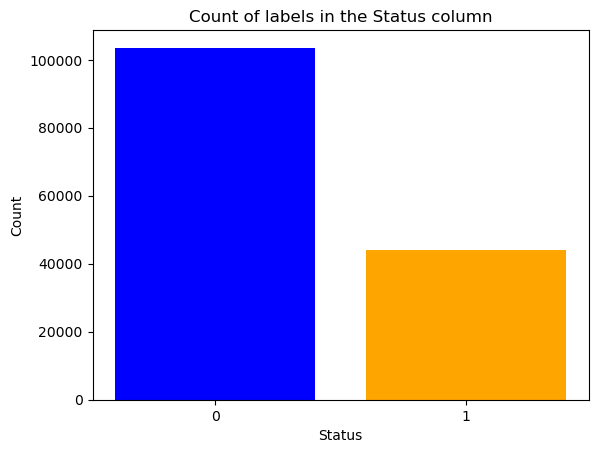

In [12]:
label_counts = count_labels(df, 'Status')
plot_bar_chart(label_counts)

---  
**Data Pre-processing:**  
**Segregating the dataset into dependant and Independant features:**

In [13]:
X, Y = df.iloc[:, :-2], df.iloc[:, -2:]

**Segregating dataset into train and test sets:**

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1)

**Scaling the data**

In [15]:
std_scaler, X_train, X_test = perform_scaling(X_train, X_test)

---
## Bahnsen's Approach:

**Creating cost matrix:**

In [16]:
FP, TP, TN, FNC = get_cost_matrix_values(Y_train)

**Cost Sensitive Logistic regression Implementation:**

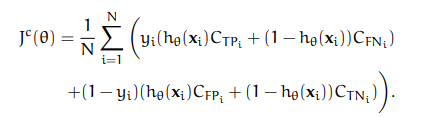

In [17]:
TO_AVOID_DIVIDE_BY_ZERO_ERROR = 1e-08
def cost_sensitive_logistic_regression_cost_function(Y, Y_hat, TP, TN, FP, FN):
        cost = (1 - Y) * (Y_hat * FP + (1 - Y_hat) * TN)
        return np.mean(cost + (Y * (Y_hat * TP + (1 - Y_hat) * FN)))

def calculate_fitness(generation_instance, weights, weight_index):
        Y_hat = compute_sigmoid(X_train @ weights)
        return np.reciprocal(cost_sensitive_logistic_regression_cost_function(Y = Y_train.iloc[:,0].values, Y_hat = Y_hat, TP = TP,
                                                                               FN = FNC, FP = FP, TN = TN) + TO_AVOID_DIVIDE_BY_ZERO_ERROR)
class ExampleDependantCostSensitiveRegression():
    def __init__(self, generation_iterations = 20, count_parents_mating = 6, training_function = calculate_fitness,
                type_of_parent_selection = 'sss', per_pop_solutions = 35, number_of_genes = 11, type_of_crossover = 'single_point', keep_parents = 1,
                 per_gene_mutation_percent = 10, type_of_mutation = 'random',
                 printing_function = lambda ga_instance: print('Generation: {} have Fitness value: {}'.format(ga_instance.generations_completed, ga_instance.best_solution()[1]))):
        super(ExampleDependantCostSensitiveRegression, self).__init__()
        self.type_of_crossover = type_of_crossover
        self.count_parents_mating = count_parents_mating
        self.printing_function = printing_function
        self.training_function = training_function
        self.per_pop_solutions = per_pop_solutions
        self.number_of_genes = number_of_genes
        self.generation_iterations = generation_iterations
        self.type_of_parent_selection = type_of_parent_selection
        self.per_gene_mutation_percent = per_gene_mutation_percent
        self.keep_parents = keep_parents
        self.type_of_mutation = type_of_mutation


    def get_genetic_instance(self):
        return pygad.GA(fitness_func = self.training_function, mutation_type = self.type_of_mutation, num_generations = self.generation_iterations,
                        parent_selection_type = self.type_of_parent_selection, sol_per_pop = self.per_pop_solutions, num_parents_mating = self.count_parents_mating,
                        on_generation = self.printing_function, num_genes = self.number_of_genes, crossover_type = self.type_of_crossover, keep_parents = self.keep_parents,
                        mutation_percent_genes = self.per_gene_mutation_percent)

    def train(self, genetic_instance):
        genetic_instance.run()

    def get_trained_weights(self, genetic_instance):
        return genetic_instance.best_solution()

    def predict(self, X_test, weights):
        print(X_test.shape)
        return compute_sigmoid(X_test @ weights)

**Runnung the genetic algorithm to obtain best weights of cost sensitive logistic regression:**

In [18]:
obj = ExampleDependantCostSensitiveRegression()
genetic_instance = obj.get_genetic_instance()
obj.train(genetic_instance)

Generation: 1 have Fitness value: 0.2294951816518564
Generation: 2 have Fitness value: 0.23065785198025288
Generation: 3 have Fitness value: 0.2357724912017201
Generation: 4 have Fitness value: 0.24394355177028595
Generation: 5 have Fitness value: 0.2454658805700795
Generation: 6 have Fitness value: 0.24782977675637569
Generation: 7 have Fitness value: 0.24935045887927657
Generation: 8 have Fitness value: 0.2502335759130209
Generation: 9 have Fitness value: 0.25288722935149643
Generation: 10 have Fitness value: 0.2540205554986274
Generation: 11 have Fitness value: 0.25515248449493794
Generation: 12 have Fitness value: 0.2556762991930102
Generation: 13 have Fitness value: 0.2570497798112678
Generation: 14 have Fitness value: 0.2574760502259689
Generation: 15 have Fitness value: 0.25777012254133574
Generation: 16 have Fitness value: 0.2582019730289493
Generation: 17 have Fitness value: 0.2585310763736054
Generation: 18 have Fitness value: 0.25869822670105674
Generation: 19 have Fitness v

In [19]:
trained_weights, _, _ = obj.get_trained_weights(genetic_instance)
print('Trained weights:', trained_weights)
predictions = obj.predict(X_test, trained_weights)
predictions = np.array([1 if x >= 0.5 else 0 for x in predictions])
cost_of_cslr = cost_sensitive_logistic_regression_cost_function(Y = Y_test.iloc[:,0].values, Y_hat = predictions, TP = 6, FN = Y_test.iloc[:,1].values, FP = 6, TN = 0)
print("Cost for Cost Sensitive Logistic Regression:", cost_of_cslr)

Trained weights: [ 7.90602719 -3.90783922  5.56697317  0.42888307 -0.95568277  1.85388848
  2.02772304  1.77603706  1.44604763  0.31482166  0.24892245]
(29528, 11)
Cost for Cost Sensitive Logistic Regression: 3.9261587925697645


---

**Comparing the results with inbuilt Logistic Regressor of ScikitLearn:**

In [20]:
simple_lr = LogisticRegression()
simple_lr.fit(X_train, Y_train.iloc[:,0])
simple_lr_pred = simple_lr.predict(X_test)

simple_lr_pred = np.array([1 if x >= 0.5 else 0 for x in simple_lr_pred])
simple_lr_cost = cost_sensitive_logistic_regression_cost_function(Y = Y_test.iloc[:,0].values, Y_hat = simple_lr_pred, TP = 6, FN = Y_test.iloc[:,1].values, FP = 6, TN = 0)
print("Cost for Simple (Sklearn's) Logistic Regression:", simple_lr_cost)

Cost for Simple (Sklearn's) Logistic Regression: 27.71167158971146


---  

**Calculating the cost saving score:**

In [21]:
print("Simple LR score Vs Cost sensitive LR saving score:", calculate_saving(cost_of_cslr = cost_of_cslr, simple_lr_cost = simple_lr_cost))

Simple LR score Vs Cost sensitive LR saving score: 0.8583211128257079


---

## Guhnmann's Approach (Variant A):

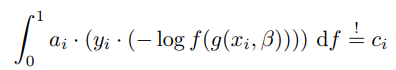

In [22]:
def weighted_logistic_loss(weights, X, y, cost_matrix):
    # Extract model parameters
    w = weights[:-1]
    b = weights[-1]

    # Compute predicted probabilities
    z = np.dot(X, w) + b
    probs = 1 / (1 + np.exp(-z))

    # Compute logistic loss with misclassification costs
    loss = -np.mean(cost_matrix[:, 0] * y[:,0] * np.log(probs + 1e-15 ) +
                    cost_matrix[:, 1] * y[:,0] * np.log(1 - probs + 1e-15 ) +
                    cost_matrix[:, 2] * (1 - y[:,0]) * np.log(probs + 1e-15 ) +
                    cost_matrix[:, 3] * (1 - y[:,0]) * np.log(1 - probs + 1e-15 ))

    return loss

In [23]:
def cost_sensitive_logistic_regression(X_train, y_train, X_test, y_test, cost_matrix):
    # Initialize weights (including bias term)
    num_features = X_train.shape[1]
    initial_weights = np.zeros(num_features + 1)

    # Define callback function to print iteration information
    def callback(weights):
        print(f"Loss: {weighted_logistic_loss(weights, X_train, y_train, cost_matrix)}")

    # Minimize the weighted logistic loss with iteration callback
    res = minimize(weighted_logistic_loss, initial_weights, args=(X_train, y_train, cost_matrix), method='BFGS', options={'maxiter': 20}, callback=callback)
    weights = res.x

    # Extract optimal weights and bias
    w = weights[:-1]
    b = weights[-1]

    # Predict on test data
    z = np.dot(X_test, w) + b
    y_pred = np.round(1 / (1 + np.exp(-z)))

    print('Finished')
    return weights

In [24]:
# Split features and target variable
X = df.iloc[:, :-2].values  # Features (columns 0 to 10)
y = df.iloc[:, -2:].values   # Target variable (column 11)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the cost matrix based on your problem
False_positive = np.full(len(y_train), 4)
True_positive = np.full(len(y_train), 4)
True_negative = np.zeros(len(y_train))
cost_matrix = np.column_stack((False_positive, y_train[:,1], True_positive, True_negative)).astype(float)

# Train cost-sensitive logistic regression model
weights = cost_sensitive_logistic_regression(X_train, y_train, X_test, y_test, cost_matrix)

Loss: 18.285193352358363
Loss: 12.109292869353467
Loss: 11.605889248016902
Loss: 10.854695121334833
Loss: 10.005322628099108
Loss: 9.938750775096162
Loss: 9.82102061061701
Loss: 9.654153797429135
Loss: 9.413174322729056
Loss: 9.159201120332899
Loss: 8.853975828469498
Loss: 8.630809870690786
Loss: 8.535067006824622
Loss: 8.494091806095675
Loss: 8.477056068355825
Loss: 8.469877809773024
Loss: 8.466031656435044
Loss: 8.462488766571093
Loss: 8.459722469851604
Loss: 8.457842755576396
Finished


In [25]:
cost_of_cslr = weighted_logistic_loss(weights,X_train, y_train, cost_matrix)

In [26]:
print("Cost for Cost Sensitive Logistic Regression (Guhnmann's approach):", cost_of_cslr)

Cost for Cost Sensitive Logistic Regression (Guhnmann's approach): 8.457842755576396


In [27]:
print("Simple LR score Vs Cost sensitive LR saving (Guhnmann's approach) score:", calculate_saving(cost_of_cslr = cost_of_cslr, simple_lr_cost = simple_lr_cost))

Simple LR score Vs Cost sensitive LR saving (Guhnmann's approach) score: 0.6947913182286504


## Results:
- Ran all the logistic regreession algorithms for 20 epochs

| Approach  | Average Cost| Savings Score wtr Simple Logistic Regression |
|:----------:|:----------:|:----------:|
| Simple Logistic Regression | 27.71 | NA |
| Cost Sensitive Logistic Regression (Bahnsen's Approach) | 3.93 | 0.85 |
| Cost Sensitive Logistic Regression (Guhnman's Approach) | 8.45 | 0.69 |
